# DoWhy: Interpreters for Causal Estimators

This is a quick introduction to the use of interpreters in the DoWhy causal inference library.
We will load in a sample dataset, use different methods for estimating the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable and demonstrate how to interpret the obtained results.

First, let us add the required path for Python to find the DoWhy code and load all required packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome.

Beta is the true causal effect.

In [3]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5, 
        num_instruments = 2,
        num_treatments=1,
        num_discrete_common_causes=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False)
df = data["df"]
df

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,0.0,0.178942,-1.542902,1.281841,-0.023741,-0.005857,1,True,8.745726
1,0.0,0.821010,-0.435864,0.613351,0.918761,1.288752,1,True,17.939133
2,1.0,0.888102,-0.410121,-2.460091,0.974205,-0.257778,2,True,11.768121
3,1.0,0.072110,0.168087,-1.284605,0.642935,-0.994114,0,True,5.540123
4,1.0,0.638847,-0.009817,1.050941,0.169217,-1.604217,2,True,7.051806
...,...,...,...,...,...,...,...,...,...
9995,1.0,0.367994,-1.669746,-0.651567,-0.176730,2.468999,3,True,23.947245
9996,1.0,0.879017,0.044243,-0.443374,0.358773,-0.873915,3,True,12.476212
9997,0.0,0.653744,-0.720789,0.607675,1.504273,1.929884,2,True,22.782048
9998,1.0,0.583433,1.597935,1.879691,0.230545,0.762837,3,True,24.890673


Note that we are using a pandas dataframe to load the data.

## Identifying the causal estimand

We now input a causal graph in the DOT graph format.

In [4]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"]
        )

In [5]:
model.view_model()

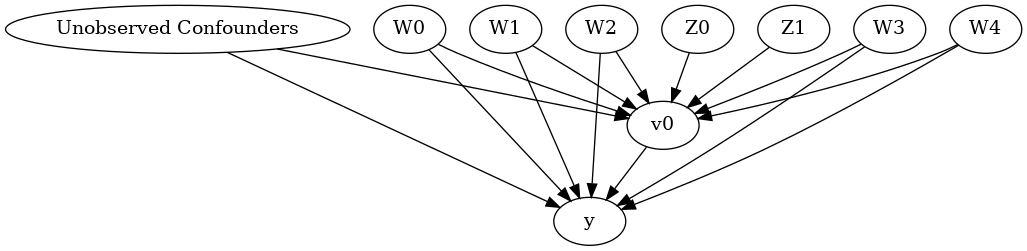

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done.

In [7]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W3,Z0,W0,W4,W1,W2,Z1))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,Z0,W0,W4,W1,W2,Z1,U) = P(y|v0,W3,Z0,W0,W4,W1,W2,Z1)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



## Method 1: Propensity Score Stratification

We will be using propensity scores to stratify units in the data.

In [8]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W3,Z0,W0,W4,W1,W2,Z1))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,Z0,W0,W4,W1,W2,Z1,U) = P(y|v0,W3,Z0,W0,W4,W1,W2,Z1)

## Realized estimand
b: y~v0+W3+Z0+W0+W4+W1+W2+Z1
Target units: att

## Estimate
Mean value: 10.214679733553648

Causal Estimate is 10.214679733553648


In [9]:
# Textual Interpreter
interpretation = causal_estimate_strat.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 10.214679733553648 in the expected value of the outcome [y], over the data distribution/population represented by the dataset.


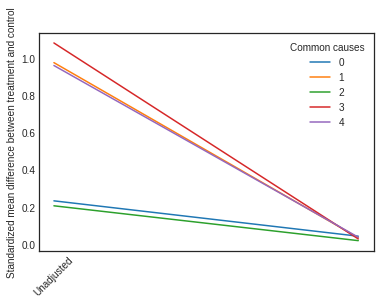

In [10]:
# Visual Interpreter
interpretation = causal_estimate_strat.interpret(method_name="propensity_balance_interpreter")

## Method 2: Propensity Score Matching

We will be using propensity scores to match units in the data.

In [11]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W3,Z0,W0,W4,W1,W2,Z1))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,Z0,W0,W4,W1,W2,Z1,U) = P(y|v0,W3,Z0,W0,W4,W1,W2,Z1)

## Realized estimand
b: y~v0+W3+Z0+W0+W4+W1+W2+Z1
Target units: atc

## Estimate
Mean value: 9.124948019480197

Causal Estimate is 9.124948019480197


In [12]:
# Textual Interpreter
interpretation = causal_estimate_match.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 9.124948019480197 in the expected value of the outcome [y], over the data distribution/population represented by the dataset.


Cannot use propensity balance interpretor here since the interpreter method only supports propensity score stratification estimator.

## Method 3: Weighting

We will be using (inverse) propensity scores to assign weights to units in the data. DoWhy supports a few different weighting schemes:
1. Vanilla Inverse Propensity Score weighting (IPS) (weighting_scheme="ips_weight")
2. Self-normalized IPS weighting (also known as the Hajek estimator) (weighting_scheme="ips_normalized_weight")
3. Stabilized IPS weighting (weighting_scheme = "ips_stabilized_weight")

In [13]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                       
─────(Expectation(y|W3,Z0,W0,W4,W1,W2,Z1))
d[v₀]                                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,Z0,W0,W4,W1,W2,Z1,U) = P(y|v0,W3,Z0,W0,W4,W1,W2,Z1)

## Realized estimand
b: y~v0+W3+Z0+W0+W4+W1+W2+Z1
Target units: ate

## Estimate
Mean value: 14.817738801842246

Causal Estimate is 14.817738801842246
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [14]:
# Textual Interpreter
interpretation = causal_estimate_ipw.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [v0] from 0 to 1 causes an increase of 14.817738801842246 in the expected value of the outcome [y], over the data distribution/population represented by the dataset.


/home/siddhant/dowhy/dowhy/interpreters/confounder_distribution_interpreter.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weight"] = df[treated] * (propensity) ** (-1) + (1 - df[treated]) * (1 - propensity) ** (-1)


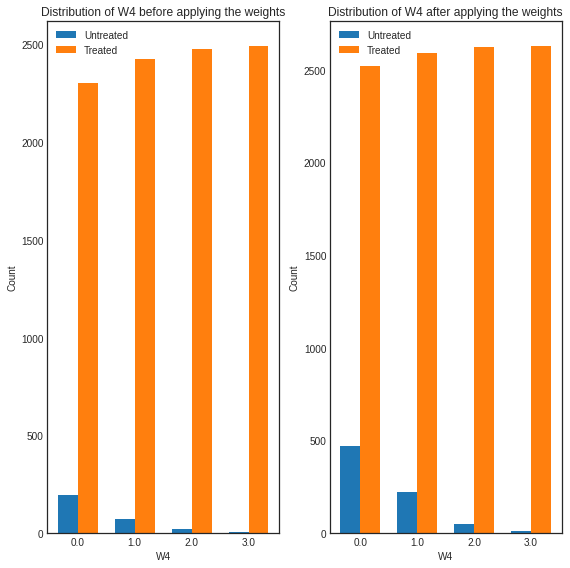

In [16]:
interpretation = causal_estimate_ipw.interpret(method_name="confounder_distribution_interpreter", fig_size=(8,8), font_size=12, var_name='W4', var_type='discrete')